In [1]:
import os
import re
import sys
import io
import sqlite3
import torch
import random
from tqdm.auto import tqdm
import networkx as nx
from torch_geometric import datasets
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import InMemoryDataset
from collections import Counter
from datetime import datetime
from joblib import Parallel, delayed

In [5]:
class DatasetGenerator:
    def __init__(self):
        self.ogb_path = 'download/OGB'
        self.planetoid_path = 'download/Planetoid'
        self.tudataset_path = 'download/TUDataset'
        
        self.sample_path = 'RWDataset/samples/samples.pt'
        self.sample_gt_path = 'RWDataset/samples/samples_gt5.pt'
        self.many_small_graph_path = 'RWDataset/many_small/graph.pt'
        self.many_small_desco_path = 'RWDataset/many_small/desco.pt'

        self.evoke_wrappers_path = 'evoke/wrappers/'
        self.run_evoke_name = 'run_evoke.py'
        self.output_evoke_path = self.evoke_wrappers_path + 'output_evoke'
        self.edgelist_graph_path = self.evoke_wrappers_path + 'edgelist_graph'
        self.output_graph_path = self.evoke_wrappers_path + 'output_graph'
        # Note: the ego network used in DeSCo contains only nodes having index < central node index
        self.edgelist_desco_path = self.evoke_wrappers_path + 'edgelist_desco'
        self.output_desco_path = self.evoke_wrappers_path + 'output_desco'
        
        self.timestamp = datetime.now().strftime("%d%H%M%S")
        
    # 1. Download the datasets, sample and save to file
    def download_sample(self, num_each_size=50, max_size=10000, visualize=False):
        # list and download all datasets manually
        # ['dblp_ct1', 'dblp_ct2', 'DBLP_v1', 'facebook_ct1', 'facebook_ct2', 'highschool_ct1', 'highschool_ct2', 'infectious_ct1', 'infectious_ct2', 'mit_ct1', 'mit_ct2', 'tumblr_ct1', 'tumblr_ct2'] in 'social networks' cannot be processed
        tudataset = {
            'molecules': ['AIDS', 'alchemy_full', 'aspirin', 'benzene', 'BZR', 'BZR_MD', 'COX2', 'COX2_MD', 'DHFR', 'DHFR_MD', 'ER_MD', 'ethanol', 'FRANKENSTEIN', 'malonaldehyde', 'MCF-7', 'MCF-7H', 'MOLT-4', 'MOLT-4H', 'Mutagenicity', 'MUTAG', 'naphthalene', 'NCI1', 'NCI109', 'NCI-H23', 'NCI-H23H', 'OVCAR-8', 'OVCAR-8H', 'P388', 'P388H', 'PC-3', 'PC-3H', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR', 'QM9', 'salicylic_acid', 'SF-295', 'SF-295H', 'SN12C', 'SN12CH', 'SW-620', 'SW-620H', 'toluene', 'Tox21_AhR_training', 'Tox21_AhR_testing', 'Tox21_AhR_evaluation', 'Tox21_AR_training', 'Tox21_AR_testing', 'Tox21_AR_evaluation', 'Tox21_AR-LBD_training', 'Tox21_AR-LBD_testing', 'Tox21_AR-LBD_evaluation', 'Tox21_ARE_training', 'Tox21_ARE_testing', 'Tox21_ARE_evaluation', 'Tox21_aromatase_training', 'Tox21_aromatase_testing', 'Tox21_aromatase_evaluation', 'Tox21_ATAD5_training', 'Tox21_ATAD5_testing', 'Tox21_ATAD5_evaluation', 'Tox21_ER_training', 'Tox21_ER_testing', 'Tox21_ER_evaluation', 'Tox21_ER-LBD_training', 'Tox21_ER-LBD_testing', 'Tox21_ER-LBD_evaluation', 'Tox21_HSE_training', 'Tox21_HSE_testing', 'Tox21_HSE_evaluation', 'Tox21_MMP_training', 'Tox21_MMP_testing', 'Tox21_MMP_evaluation', 'Tox21_p53_training', 'Tox21_p53_testing', 'Tox21_p53_evaluation', 'Tox21_PPAR-gamma_training', 'Tox21_PPAR-gamma_testing', 'Tox21_PPAR-gamma_evaluation', 'UACC257', 'UACC257H', 'uracil', 'Yeast', 'YeastH', 'ZINC_full'],
            'bioinformatics': ['DD', 'ENZYMES', 'KKI', 'OHSU', 'Peking_1', 'PROTEINS'],
            'computer vision': ['COIL-DEL', 'COIL-RAG', 'Cuneiform', 'Fingerprint', 'Letter-high', 'Letter-low', 'Letter-med', 'MSRC_9', 'MSRC_21', 'MSRC_21C', 'FIRSTMM_DB'],
            'social networks': ['COLLAB', 'deezer_ego_nets', 'github_stargazers', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'REDDIT-MULTI-5K', 'REDDIT-MULTI-12K', 'reddit_threads', 'twitch_egos', 'TWITTER-Real-Graph-Partial'],
            'synthetic': ['COLORS-3', 'SYNTHETICnew', 'Synthie', 'TRIANGLES']
        }
        planetoid = ['Cora', 'CiteSeer', 'PubMed']
        ogb = ['ogbg-molhiv', 'ogbg-molpcba', 'ogbg-ppa']

        graph_size = []

        # molecule datasets
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root=self.ogb_path)
            for graph in (tqdm(dataset)):
                graph_size.append(graph.num_nodes)

        # bioinformatics datasets
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)
        dataset = PygGraphPropPredDataset(name=ogb[2], root=self.ogb_path)
        for graph in tqdm(dataset):
            graph_size.append(graph.num_nodes)

        # computer vision datasets
        for name in tudataset['computer vision'][-4:]:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # social networks datasets
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # citation networks datasets
        for name in planetoid:
            dataset = datasets.Planetoid(root=self.planetoid_path, name=name)
            for graph in tqdm(dataset):
                graph_size.append(graph.num_nodes)

        # compute the number of graphs for each node size
        graph_size_count = [0] * (max(graph_size) + 1)
        for size in graph_size:
            graph_size_count[size] += 1
            
        print('Number of graphs of each size: ', graph_size_count)
        
        # compute the probability of sampling a graph with size i
        sample_p = [0] * (max_size + 1)
        for i in range(max_size):
            if graph_size_count[i] > 0:
                sample_p[i] = min(num_each_size * 2 / graph_size_count[i], 1)

        graphs_selected = [[] for _ in range(max_size + 1)]

        # sample molecule graphs
        for name in tudataset['molecules']:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    # push the graph to the list with probability sample_p[graph.num_nodes]
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules', name))
        for name in ogb[:2]:
            dataset = PygGraphPropPredDataset(name=name, root=self.ogb_path)
            for graph in (tqdm(dataset)):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'molecules', name))

        # sample bioinformatics graphs
        for name in tudataset['bioinformatics']:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'bioinformatics', name))
        dataset = PygGraphPropPredDataset(name=ogb[2], root=self.ogb_path)
        for graph in tqdm(dataset):
            if 0 < graph.num_nodes <= max_size:
                if torch.rand(1).item() < sample_p[graph.num_nodes]:
                    graphs_selected[graph.num_nodes].append((graph, 'bioinformatics', ogb[2]))

        # sample computer vision graphs
        for name in tudataset['computer vision'][-4:]:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'computer vision', name))

        # sample social networks graphs
        for name in tudataset['social networks'][:-1]:
            dataset = datasets.TUDataset(root=self.tudataset_path, name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'social networks', name))

        # sample citation networks graphs
        for name in planetoid:
            dataset = datasets.Planetoid(root=self.planetoid_path, name=name)
            for graph in tqdm(dataset):
                if 0 < graph.num_nodes <= max_size:
                    if torch.rand(1).item() < sample_p[graph.num_nodes]:
                        graphs_selected[graph.num_nodes].append((graph, 'citation networks', name))

        # randomly select num_each_size graphs for each size i
        graphs_selected_copy = graphs_selected.copy()
        for i in range(1, max_size + 1):
            if len(graphs_selected_copy[i]) > num_each_size:
                graphs_selected_copy[i] = [graphs_selected_copy[i][j] for j in torch.randperm(len(graphs_selected_copy[i]))[:num_each_size]]

        # draw the picture for number of graphs of each size
        if visualize:
            fig, axs = plt.subplots(1, 1)
            axs.bar(range(0, max_size+1), [len(graphs_selected_copy[i]) for i in range(max_size+1)])
            axs.set_xlabel('Number of nodes')
            axs.set_ylabel('Number of graphs')
            axs.set_title('Number of graphs of each size')
            plt.show()

        # convert the graphs to torch_geometric.data.Data object
        print('Converting the graphs to torch_geometric.data.Data object...')
        graphs_nx = [to_networkx(d[0], to_undirected=True, remove_self_loops=True) for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        graphs_pyg = [from_networkx(g.subgraph(max(nx.connected_components(g), key=len))) for g in graphs_nx]
        domains = [d[1] for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        sources = [d[2] for i in range(1, max_size+1) for d in graphs_selected_copy[i]]
        for i, g in enumerate(graphs_pyg):
            g.domain = domains[i]
            g.source = sources[i]
        # remove all the graphs with 0 edge
        graphs_pyg = [g for g in graphs_pyg if g.num_edges > 0]
        # keep only 1 graph with num_nodes=2 and num_edges=1
        graphs_pyg = graphs_pyg[:1] + [g for g in graphs_pyg[1:] if not (g.num_nodes == 2 and g.num_edges == 2)]

        # save the graphs to file
        torch.save(graphs_pyg, self.sample_path)
        
    # 2. generate the ground truth for all graphs sampled and split the dataset into train, val and test
    def ground_truth(self):
        if not os.path.exists(self.sample_path):
            print('No sample file found! Start to download and sample...')
            self.download_sample()            
        graphs = torch.load(self.sample_path)
        print('Number of graphs sampled: ', len(graphs))
        
        # use EVOKE to compute ground truth
        # 2.1 generate edge_list files EVOKE needs 
        if os.path.exists(self.edgelist_graph_path):
            os.rename(self.edgelist_graph_path, f"{self.edgelist_graph_path}_{self.timestamp}")
        os.mkdir(self.edgelist_graph_path)
        for i, g in tqdm(enumerate(graphs), total=len(graphs), desc='Generating edge list files'):
            with open(f'{self.edgelist_graph_path}/rw_{i}.edgelist', 'w') as f:
                f.write(f'{g.num_nodes} {g.num_edges//2}\n')
                for edge in g.edge_index.T:
                    if edge[0] < edge[1]:
                        f.write(f'{edge[0]} {edge[1]}\n')
        print('Edge list files generated')

        # 2.2 compute the ground truth using 'run_ego.py' with EVOKE
        # NOTE: used ORCA & graph match in old version
        # rename the output_evoke and output_graph folders if they exist
        if os.path.exists(self.output_evoke_path):
            os.rename(self.output_evoke_path, f"{self.output_evoke_path}_{self.timestamp}")
        os.mkdir(self.output_evoke_path)
        if os.path.exists(self.output_graph_path):
            os.rename(self.output_graph_path, f"{self.output_graph_path}_{self.timestamp}")
        os.mkdir(self.output_graph_path)
        # run the EVOKE to compute the ground truth
        os.system(f'cd {self.evoke_wrappers_path} && python {self.run_evoke_name} graph')
        # read in the ground truth and add gt_induced_le5 & gt_noninduced_le5 to the graphs
        for i, g in tqdm(enumerate(graphs), desc='Adding ground truth to graphs'):
            noninduced = torch.load(f'{self.output_graph_path}/noninduced_rw_{i}.pt')
            induced = torch.load(f'{self.output_graph_path}/induced_rw_{i}.pt')
            g.gt_noninduced_le5 = noninduced
            g.gt_induced_le5 = induced

        # 2.3 compute some features for the graphs
        for g in tqdm(graphs):
            nx_g = to_networkx(g, to_undirected=True)
            g.degree_avg = nx_g.number_of_edges() / nx_g.number_of_nodes()
            g.degree_max = max(dict(nx_g.degree()).values())
            g.clustering = nx.average_clustering(nx_g)
            g.diameter = nx.diameter(to_networkx(g, to_undirected=True))
        # sort the graphs by num_nodes and then by num_edges
        graphs = sorted(graphs, key=lambda x: (x.num_nodes, x.num_edges))
        # save the ground truth to file
        torch.save(graphs, self.sample_gt_path)
        print(f'Ground truth & features computed and saved to {self.sample_gt_path}')

    # 3. generate the dataset for DeSCo
    # NOTE: don't use this function in the class, use the 'generate_desco_dataset.py'
    def generate_desco_dataset(self, file=None):
        graphs = torch.load(self.sample_gt_path if file is None else file)
        print('GNN dataset loaded, total number of graphs: ', len(graphs))

        if os.path.exists(self.edgelist_desco_path):
            os.rename(self.edgelist_desco_path, f"{self.edgelist_desco_path}_{self.timestamp}")
        os.mkdir(self.edgelist_desco_path)
        if os.path.exists(self.output_evoke_path):
            os.rename(self.output_evoke_path, f"{self.output_evoke_path}_{self.timestamp}")
        os.mkdir(self.output_evoke_path)
        if os.path.exists(self.output_desco_path):
            os.rename(self.output_desco_path, f"{self.output_desco_path}_{self.timestamp}")
        os.mkdir(self.output_desco_path)

        # 3.1 for each graph in graphs, get desco-egonetwork around each node and combine them into a whole graph
        # 3.2 save the edgelists and indices to file
        # NOTE: multiprocessing has some bug here, I use joblib to replace it
        def get_ego_4h_graph(g_i):
            g = to_networkx(g_i[0], to_undirected=True)
            i = g_i[1]
            ego_4h_g = []
            for node in g.nodes:
                ego_full = nx.ego_graph(g, node, radius=4)
                # delete nodes with index larger than node
                ego_full = ego_full.subgraph([n for n in ego_full.nodes if n <= node])
                # get the connected components of the ego graph and select the one contains the node
                connected_components = list(nx.connected_components(ego_full))
                for cc in connected_components:
                    if node in cc:
                        ego_full = ego_full.subgraph(cc)
                        break
                ego_4h_g.append(ego_full)

            G = nx.Graph()
            index_map = {}
            for index, ego in enumerate(ego_4h_g):
                local_map = {}
                for node in ego.nodes:
                    local_map[node] = len(G.nodes) + len(local_map)
                index_map[index] = local_map[index]
                G.add_nodes_from(local_map.values())
                relabeled_edges = [(local_map[edge[0]], local_map[edge[1]]) for edge in ego.edges()]
                G.add_edges_from(relabeled_edges)

            with open(f'{self.edgelist_desco_path}/rw_{i}.edgelist', 'w') as f:
                f.write(f'{len(G.nodes)} {len(G.edges)}\n')
                for edge in G.edges:
                    f.write(f'{edge[0]} {edge[1]}\n')
            with open(f'{self.edgelist_desco_path}/rw_{i}.index', 'w') as f:
                # write index_map.values as a list into f
                f.write(' '.join([str(x) for x in index_map.values()]))

        _ = Parallel(n_jobs=min(os.cpu_count(), 32))(
            delayed(get_ego_4h_graph)(g_i) for g_i in tqdm([(g, i) for i, g in enumerate(graphs)], desc='Generating DeSCo ego networks')
        )
        print('DeSCo ego networks generated, edge list files generated and saved to files')

        # 3.3 compute the ground truth using 'run_ego.py' with EVOKE
        os.system(f'cd {self.evoke_wrappers_path} && python {self.run_evoke_name} desco')
        # read in the ground truth and add gt_induced_le5_desco & gt_noninduced_le5_desco to the graphs
        for i, g in tqdm(enumerate(graphs), desc='Adding desco ground truth to graphs', total=len(graphs)):
            noninduced = torch.load(f'{self.output_desco_path}/noninduced_rw_{i}.pt')
            induced = torch.load(f'{self.output_desco_path}/induced_rw_{i}.pt')
            g.gt_noninduced_le5_desco = noninduced
            g.gt_induced_le5_desco = induced
        # save the graphs to file
        torch.save(graphs, self.sample_gt_path)
        print('DeSCo ground truth computed and saved')
        
    # 4. visualize the split dataset(train, val, test) if needed
    def visualize_graphs(self, file_path=None):
        if file_path is None:
            file_path = self.sample_gt_path
        graphs = torch.load(file_path)
        print('Data loaded, total number of graphs: ', len(graphs))

        # features of the graphs: (#node, #edge, domain) as key, #that graph as value
        features = Counter([(g.num_nodes, g.num_edges, g.domain) for g in graphs])
        # convert the features to list
        features_list = [(key[0], key[1], key[2], value) for key, value in features.items()]
    
        domains = ['bioinformatics', 'computer vision', 'social networks', 'molecules', 'citation networks']
        # set different shapes for different domains
        shapes = ['*', 'D', 's', 'o', 'x']
        # use colormap 'Set3' to represent the domain
        # cmap = plt.colormaps['Set1']
        cmap = ['green', 'blue', 'purple', 'red', 'black']
        size_times = [50, 40, 2, 0.1, 200]
    
        # 1. draw the dot plot with x-axis=num_nodes, y-axis=num_edges for each domain separately
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        for index, domain in enumerate(domains[:4]):
            x = [f[0] for f in features_list if f[2] == domain]
            y = [f[1] for f in features_list if f[2] == domain]
            s = [size_times[index]*f[3]**2 for f in features_list if f[2] == domain]
            axs[index].scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=s, alpha=0.3)
            axs[index].legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.supxlabel('num_nodes', fontsize=12)
        fig.supylabel('num_edges', fontsize=12)
        fig.subplots_adjust(left=0.08, right=0.98, bottom=0.15, top=0.9, wspace=0.2)
        fig.savefig('plots/n_vs_m_sep.pdf', bbox_inches='tight')
    
        # 2. draw the dot plot with x-axis=num_nodes, y-axis=num_edges for all domains together
        features_list_no_count = []
        for key, value in features.items():
            for _ in range(value):
                features_list_no_count.append(key)
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        for index, domain in enumerate(domains):
            x = [f[0] for f in features_list_no_count if f[2] == domain]
            y = [f[1] for f in features_list_no_count if f[2] == domain]
            axs.scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=10, alpha=0.6)
            axs.legend()
        # set the x-axis and y-axis labels for the whole figure
        fig.supxlabel('num_nodes', fontsize=12)
        fig.supylabel('num_edges', fontsize=12)
        fig.savefig('plots/n_vs_m_tog.pdf', bbox_inches='tight')
    
        # 3. draw the dot plot with x-axis=domain, y-axis=num_nodes/num_edges/density of the graphs in graphs_pyg
        fig, axs = plt.subplots(1, 3, figsize=(24, 4))
        axs[0].scatter([f[2] for f in features_list_no_count], [f[0] for f in features_list_no_count], s=0.15, alpha=1)
        axs[0].set_ylabel('num_nodes')
        axs[1].scatter([f[2] for f in features_list_no_count], [f[1] for f in features_list_no_count], s=0.15, alpha=1)
        axs[1].set_ylabel('num_edges')
        axs[2].scatter([f[2] for f in features_list_no_count], [f[1]/f[0] for f in features_list_no_count], s=0.15, alpha=1)
        axs[2].set_ylabel('density')
        fig.supxlabel('domain')
        fig.savefig('plots/domain_vs_n_m_d.pdf', bbox_inches='tight')
    
        # 4. draw the graph to show the distribution of the graph node size, edge size, and density
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        node_size_distribution = [0 for _ in range(max([f[0] for f in features_list_no_count])+1)]
        edge_size_distribution = {}
        density_distribution = {}
        for f in features_list:
            node_size_distribution[f[0]] += f[3]
            edge_size_distribution[f[1]] = edge_size_distribution.get(f[1], 0) + f[3]
            density = f[1] // f[0]
            density_distribution[density] = density_distribution.get(density, 0) + f[3]
    
        axs[0].hist([x[0] for x in features_list_no_count], bins=10, linewidth=0.5, edgecolor='black')
        axs[0].set_xlabel('num_nodes')
        # set the x-axis as log scale
        axs[1].hist([x[1]//2 for x in features_list_no_count], bins=100, linewidth=0.5, edgecolor='black')
        axs[1].set_xlabel('num_edges')
        # set the x-axis and y-axis as log scale
        axs[2].hist([x[1]//2/x[0] for x in features_list_no_count], bins=50, linewidth=0.5, edgecolor='black')
        axs[2].set_xlabel('density')
        fig.supylabel('count')
        fig.subplots_adjust(left=0.06, right=0.98, bottom=0.15, top=0.9, wspace=0.2)
        fig.savefig('plots/n_m_d_distribution.pdf', bbox_inches='tight')
    
        # 5. local induced counts distribution
        pattern_index = [3, 6, 7, 14, 13, 16, 15, 17, 18, 31, 30, 29, 35, 36, 34, 38, 37, 40, 42, 41, 44, 43, 46, 45, 47, 48, 49, 50, 51, 52]
        pattern_dis_induced = torch.cat([g.gt_induced_le5.T for g in graphs], dim=1)
        print('pattern_dis_induced shape: ', pattern_dis_induced.shape)
        fig, axs = plt.subplots(5, 6, figsize=(24, 20))
        for i, ax in enumerate(axs.flatten()):
            ax.hist(pattern_dis_induced[i].numpy(), bins=10, linewidth=0.5, edgecolor='black')
            ax.set_yscale('log')
            ax.set_title(f'pattern {i}')
            ax_p = ax.inset_axes([0.7, 0.7, 0.3, 0.3])
            pattern = nx.graph_atlas(pattern_index[i])
            nx.draw(pattern, nx.spring_layout(pattern, seed=0), ax=ax_p, node_size=20, with_labels=False)
        # set y label for the whole graph
        fig.supxlabel('local induced counts')
        fig.supylabel('number of nodes')
        fig.subplots_adjust(left=0.05, right=0.98, bottom=0.05, top=0.9, wspace=0.2, hspace=0.3)
        fig.savefig('plots/local_induced_counts_distribution.pdf', bbox_inches='tight')
        
    # 5. sample graphs again from the sampled dataset to generate the dataset for GNN methods(except DeSCo)
    def sample_gnn_dataset(self):
        if not os.path.exists(self.sample_gt_path):
            print('No ground truth file found! Start to compute the ground truth...')
            self.ground_truth()
        graphs = torch.load(self.sample_gt_path)
        print('Dataset with ground truth loaded, total number of graphs: ', len(graphs))

        # sample 1200/300/150 graphs in the regions respectively as MSS, MSM, and MSL
        index_200 = list(map(lambda x: x.num_nodes >= 200, graphs)).index(True)
        index_600 = list(map(lambda x: x.num_nodes >= 600, graphs)).index(True)
        MSS = random.sample(graphs[:index_200], 1200)
        MSM = random.sample(graphs[index_200:index_600], 300)
        MSL = random.sample(graphs[index_600:], 150)
        
        # save the datasets to files
        # Note: not split into train, val and test, users can do this with their own split strategy. Checked that if split into 4:1:1, the sum of num_nodes in each part is also close to 4:1:1
        torch.save((MSS, MSM, MSL), self.many_small_graph_path)
        print(f'Dataset with MSS, MSM, MSL saved to {self.many_small_graph_path}')

Data loaded, total number of graphs:  26435
(2, 2, 'molecules', 1)
(3, 4, 'molecules', 39)
(3, 4, 'social networks', 1)
(3, 4, 'bioinformatics', 1)
(3, 6, 'bioinformatics', 1)
(4, 6, 'molecules', 45)
(5, 8, 'molecules', 49)
(5, 10, 'molecules', 6)
(6, 10, 'molecules', 37)
(6, 12, 'molecules', 8)
(7, 12, 'molecules', 29)
(7, 14, 'molecules', 17)
(7, 42, 'social networks', 3)
(8, 14, 'molecules', 26)
(8, 16, 'molecules', 20)
(8, 32, 'bioinformatics', 1)
(8, 56, 'social networks', 1)
(9, 16, 'molecules', 1)
(9, 18, 'molecules', 2)
(9, 72, 'molecules', 49)
(10, 18, 'molecules', 10)
(10, 20, 'molecules', 28)
(10, 22, 'molecules', 11)
(10, 24, 'molecules', 4)
(11, 20, 'social networks', 6)
(11, 20, 'molecules', 4)
(11, 22, 'molecules', 18)
(11, 22, 'social networks', 2)
(11, 24, 'molecules', 17)
(11, 24, 'social networks', 3)
(12, 22, 'social networks', 2)
(12, 22, 'molecules', 1)
(12, 24, 'molecules', 1)
(12, 26, 'molecules', 3)
(12, 46, 'social networks', 1)
(12, 126, 'molecules', 1)
(12, 

IndexError: list index out of range

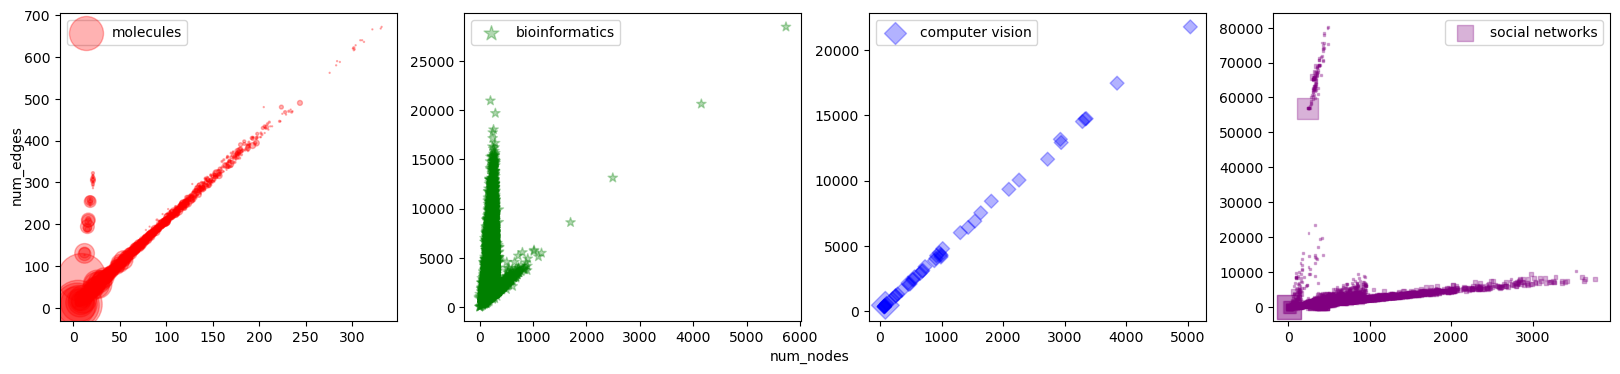

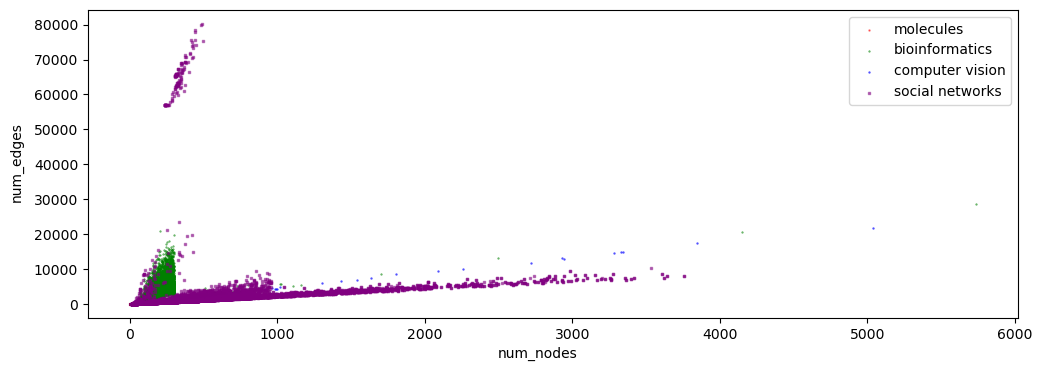

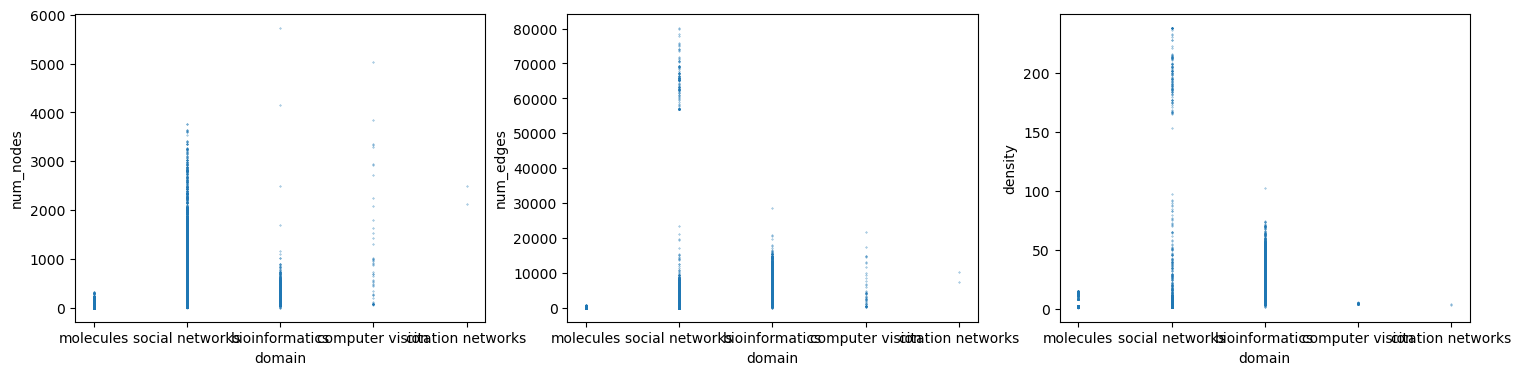

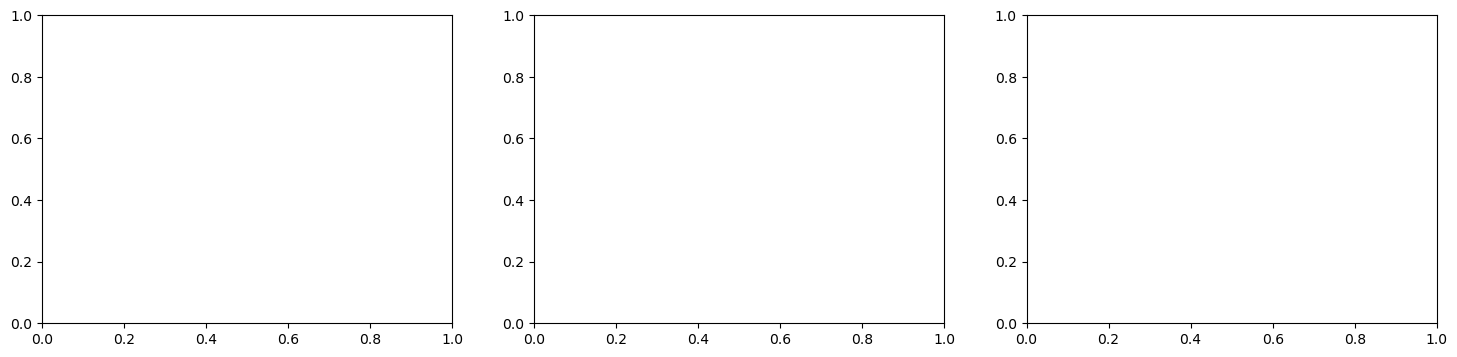

In [6]:
DatasetGenerator().visualize_graphs()